# Demo - Probabilistic Fourier with AR model on coefficients

This file provides an demo of the probabilistic Fourier framework as outline in "Bayesian spectrum estimation of unevenly sampled data" - Qi et al.

$$ {\bf{s}}_t = {\bf{s}}_{t-1} + {\bf{w}}_t $$
$$ {\bf{y}}_t = C^\top {\bf{s}}_t + {\bf{v}}_t $$

## Load packages and functions

In [1]:
using ForneyLab       # based on last official release
using LinearAlgebra
using Plots
using PyPlot
using ProgressMeter
using Compat
using WAV
using Base64
using FileIO
using HDF5
using FLAC
using DSP
using FFTW
using LAR
using LAR.Node
using Distributions

include("../functions/auxiliary/buffer.jl")
include("../functions/auxiliary/audioplayer.jl")
include("../functions/auxiliary/workflow.jl")
include("../functions/auxiliary/fourier.jl")
;

## Settings

In [2]:
# data loading
sound_file = "../data/woman.wav"   # specify sound location
fs_desired = 8000                  # specify desired sampling frequency

# input buffer parameters
step_size = 30                      # specify step size of buffer
buffer_size = 30                    # specify size of buffer

# probabilistic fourier parameters 
var_observation = 1e-4               # specify observation noise var
freq_bins = 15
freq = collect(fs_desired/(2*(freq_bins+1)):fs_desired/(2*(freq_bins+1)):(fs_desired/2-fs_desired/(2*(freq_bins+1))))

# AR modelling
AR_order = 1
iterations = 5
;

## Load data

In [3]:
# load and process speech signal
x_time, fs_time = wavread(sound_file, format="native")
fs_time = Int(fs_time)
x_time = x_time[1*fs_time+1:4*fs_time]
x_time = resample(x_time, fs_desired/fs_time)
x_time = 100*x_time/var(x_time)
x_time_clean = x_time
x_time = x_time_clean + rand(Distributions.Normal(0, sqrt(var_observation)), length(x_time_clean))

# specify time axis
t = collect((1:length(x_time))/fs_desired)

# create audioplayer
audioplayers(x_time, fs=fs_desired)
;

<source src="data:audio/wav;base64,UklGRjx3AQBXQVZFZm10ICgAAAD+/wEAQB8AAAB9AAAEACAAFgAgAAAAAAADAAAAAAAQAIAAAKoAOJtxZGF0YQB3AQCyNdq9fvMVvmWapL3/Q6a9AFZSvc9bhrxbqog9APvGPRAxIz4Lg4A+WHB8Ph/CYD42B28+fjEOPqQ1kTw0E9m8gpAQvfZh8b0tskW+wysQvpkeir0M0Ei9NlMOvdMfnzuJZE89x4eEPT5Ryjv7lda8zlRCvfIIob2wOry9Fdb0vYdKDL5hWv697KzDvTWHqb0slyS9vLzHPIb18D0Vkx4+9ghSPrDydT5RRIQ+Klt7PrXWLj6hWjI9gMOlvG7f7rzt0ey9ZHBEvu/zRL46PMG93MMTvXsnL71EYKK8wr5EPXJ7Mj2lcik9H/83O+sSn7z3mYK9aEtyvWmZw72eAgC+nWbqvTVC6r0ykKy99KMovWtnpDxxTQM+PlZQPhL/Zz6eIpU+HaeTPvX/UT5pj5I9V2r/O3d167qn+Ii97DxdvooiYb6vnB6+naimvQXN1b0Wq4i90GfhPMfRvj3RUn89VBWQPARZNTvB+gw93J8mvREjr72+yea9GSgBvjOU+L2uada9Ee+5vQwgHbwpQqo9KwMyPgpURj68gmM+SbCSPkeUfT6cwwQ+nCqAPMJajjzUIUK8RWIZvp5HgL6MpS++BlvKvUNN4r2U/ce94YoqvfctGD081hA9rD9VPYJvKjyYy/I73+GSPJY+Bzt4MqW9qCPbva6cgb2mOLe8QWLlvCirWT06C0I+gjdnPgZ5bD7VS3I+dZUJPidUiz16tDc9y2b0OnlLGL6DE1O+hK4Jvrj/A75WRhS+ceTXvUNBCDzztZI94VaiPf2apz2RyYU9syxOPUQAOT1SCnE8ZjhwveCcCr7Gwui9sFO4vTbELL4Skge+wcuqvMAUDz0ysD891Xi3PXDXDT4ZeCw+GCgWPorQCT4vYtM9tdVLPW49wzww99G8V6MDvagciLzaBaS9RLT3vR5nsL0tFEu9MRGGvc9yOb3+zT68qq0TO+NUfbvAiB69LVG6vBX9BbwCSvO7VImxu208zzxKrpo9pLL9PeeoMD5b5lM+979jPkmKYj70YKg9XruWvOYdvDwRuC69iwtGvkLXY74vsa+9QRuqvYJwIr5Lxte9M3NPPeMRvD23RHM9hC+kPZs3/j0/9e89EpG6PTcDjTxFFRa9Xqe6vXJxl73Usvm9T3AMvoXaur32Liy9ELAdvQXPBL1/OKK74+MgPTkfaj2hfDw9jQ4PPQHNRT3CfXA8U4bpvAbcZL15X5u8iJ2tvMFiPb3F5Em8kdpHvKBrzDtIMxQ7r9toPDtf07qHvuK7OTkLPIcpBbwh0v284dbBuzH4lbt0cKi8Z3U1Ow6ACzwjC3Q8YTiUPOFYwzypx/E8dvk4PfdkLj2tBi49CRwAPalhvjwLwHK895cXvUY/7bw4vDC9GUSxvPUEVb1Relm9/faMvGxINr1f3hG9oTB0vHEOgby5I7+7Mz+HvKYHM7pfPVQ7kx/TPGmpRT3a6V09m+FAPSKbUT1Vv1Y9vz1wPYVlSD0VXwI9WMqTPMxd2Ttn5S29bOeSvdyDoL1ko6q9aIyQvatCv70i16u9IfGCvboXML15zw+9wDGdvNa2jLgvXQ88A/+uPOrISj2RCxY96VZcPcXhwz17Qtw9tMb/PSH23T1g5989tSGWPboxGT3bXo68qciDvdJO+L17++y9Ta8HviCOKr4OGvy93BSqvfnVeb1pxpi9CAK9vHEPlTt/KQo9BLgpPcS0hj3Xvqc9JVOuPekwsD0iwOw9Mj4cPhXRKz7g7uI9zCz7PFrGjTwrYjI9gVcpvd7ZB7566bu9FQJnve/d271V3ga+GkGJvVvrszuKgsu8V7aiu3/mID0Cj5s9xa8uPdg6njw5wTw9FKvlPK7oAL0rvMS4PLE2vXprLr2EqoS9NHaBvZQja71xGEW9HDnbvKfluLyxXGi8fXBBvFvHEby4exU8L4tzPLHjdbzdB1O81itNPHKHc7kS3d47htbOu8g+2zsDDhk8PbW8vH5SATvnPqG7P9jsOsyg+bwL1C08tXqvPIBjMzzFMCw8dZIHO5+TvTwR+To7JTQlu3qA/rurZac7SS0PPSOa9TsPtbw8AwJRPDk9CDzxQUS7h+E6u8ErrrtU3TC8Q1WFvN+ZW7zNYpi8d3Pvu1/jirytm0+7RUHLuqxF+LuKXjg8+uXDPGnNBz13r6u8+3MAPMR2wTyV9TQ8tmObOpWLVDzI3A89sSTiO/wCdzxbitS8spOVvDP+4Tu7wnG7b/F2ux/+wrqmZ987cYXPuweEoTyyQp28TvIFvKuAPbw1x5A8i38OPM3EszkUvAs8IDzyPJkSoDu/LHW8hpHgO7mfiDwhRIg8w9ieu4a5+TviefI8qUsbuvZAdToAENw87s7DOu5ANzyElZ88VzahPKky5rtju8U71LmXPA3KjrzKRQk76lsWu33lxTnGJVg8l7sDvPkIvrzO4Lc7Lz2FPC4tO7yTC+m8lVBQPJd/mDwnV3W8BIc8u5oUZjuXs3u8HPmZvLkZDz2D/ug604IXvQzPhry4HYY7p6EEvC1B57xPeN06RIU3O2IdOrz5q6y8enfZvG3hMzoG9Zw8jp2nvGf8F73BDK86l3xdPJso9LzW4oq8niQPPIu7aby2bpi8rg80u2zEcbxyuD68HMi2vCLUKrwL7lC8Zt0evPWIh7zgq0y7iXIUuyRDkruJU3G8bvyPOQo/RjyvmyA8cg3wu6KHDrynb9S7VAooPBpzrbrZPcs722GVvDevLjz6Oya5YMtxvFhrTrxuf2u8bQSTvNQepjz3LNu7H2foO0WyrTtnY027OMVOu2dR+LpS07W8q6zkvDZBujv51Xw62z/CvEzlLLw1TyS8Yk4YOhBXFrzZesW6NOAGvOBlFLwHmyI7MemIOhCjiTwOVeW7pQAJO+Nr5zvDwSO8WQoYvNZ5IDx2R+u7hLPqujylqbs3Fog8KjpmOrSnObwGgy+8e+wMPG91ELzzfes7O4rgu5NoT7sw2rc6JooRPPBoWTureCQ8z7oAOk4YiDzJdQu7wrWlu+dLVLsR6S48sCw1uwEPLzxe+YU85RMEPEz/iDw39Vg7k/u7O/VYl7twQqe7cBA7u+wpczzbSaC71V+iPMiwtbuQIvm6Onq7PBI5z7rCkci7kEcnPJAWabscr+A7L9fqOhl9FjxRWfq6CxGHPIbRuDt1sVc76cbHOpA4FzvlTtg5uaQMvNR6BzxiUj27I9AmuwkME7wpmLC63nUfPB3XWzymp187H8aGu/TFA7weZcu7Vq6ovMdxfbyqs4S7i7byuxpNHrwulo47TlIlum+/rLz2PvW7Zd4ROrCLGzxH/Xu7tvMcu/O7DrzJb1G8OSxyvPsRrbtRpb68zx22vOuGLrtS/zC8QYi6vCBtFbzxp9S8iDzru1ERQLwBLXw7dzFru4ReDLzg1EO8UPU2vLygEL3rSx69QEkUPBVgQbw0N9G8UGBivALvQbvETdo6XFo6vEc5Crw7pQS8jHyZu1u/T7yr4I87xYQ8vEztGrx4NoQ8ugBwvIZSQLxqZvS8PKy5vGaosbvUvrq7rV9kvNI2gjsTyE06FGeOu8atsTvg0ZG86YvzvAxK5TobQEm8vw9nu5zuk7xthys7bR/AuyV+ObvPNyQ6Y0gOvBbMh7rI06a83vWOPDID2jvs57i6VUMUPPFVzrtPkaq7YMmJu68tl7trkIO7NMqRO5fG1TusGR49FImlup08+ztjS088m0smPGd7sjxHQMK6lF9LPOTY/jukqeQ8pxrIu4ZR8zs9+d+6St26O6RjazxZtT46MTxiPELMgryTRgg8y/lru+SHEzzw6Sm8MkwePPkAjzu6EX48kDbbO5V/BLp93Ai6AMbmu/6txjxxV1o8yXAUumNNDjzlx

## Visualize data

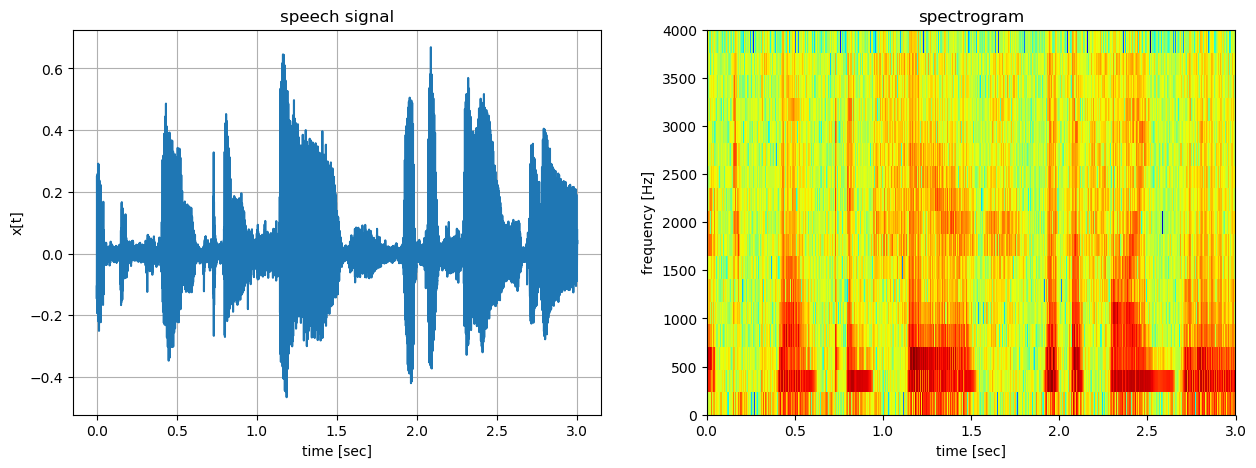

In [4]:
# create figure with subplots
_, ax = plt.subplots(ncols=2, figsize=(15,5))

# plot speech signal as a function of time
ax[1].plot(t, x_time)

# plot spectrogram of speech signal
plot_spectrogram(spectrogram(x_time, 32, 0, fs=fs_desired), fs_desired, ax=ax[2])

# visual modifications
ax[1].grid(), ax[1].set_ylabel("x[t]"), ax[1].set_xlabel("time [sec]"), ax[1].set_title("speech signal"), ax[2].set_title("spectrogram")
;

## Specify generative model

In [5]:
# create factor graph
fg = FactorGraph()

# placeholders
z_min = Array{Variable,1}(undef, 2*length(freq))
γ = Array{Variable,1}(undef, 2*length(freq))
θ = Array{Variable,1}(undef, 2*length(freq))
z = Array{Variable,1}(undef, 2*length(freq))

# specify observation noise
@RV v ~ GaussianMeanVariance(zeros(buffer_size), var_observation*Ic(buffer_size))

# specify previous hidden state (spectral component buffer)
for k = 1:2*length(freq)
    @RV [id=pad(:z_min,k)] z_min[k] ~ GaussianMeanVariance(placeholder(pad(:μ_z_min, k), dims = (AR_order,)),
                                        placeholder(pad(:Σ_z_min, k), dims = (AR_order, AR_order)))
    @RV [id=pad(:γ,k)] γ[k] ~ ForneyLab.Gamma(placeholder(pad(:a_γ,k)), placeholder(pad(:b_γ,k)))
    @RV [id=pad(:θ,k)] θ[k] ~ GaussianMeanVariance(placeholder(pad(:μ_θ,k), dims=(AR_order,)), placeholder(pad(:Σ_θ,k), dims=(AR_order, AR_order)))
    @RV [id=pad(:z,k)] z[k] ~ LAR.Autoregressive(θ[k], z_min[k], γ[k])
end

# specify Fourier matrix
Ceme1 = Array{Variable,1}(undef, 2*length(freq))
for k=1:2*length(freq)
    @RV Ceme1[k] 
    placeholder(Ceme1[k], pad(:Ceme1,k), dims = (buffer_size, AR_order))
end

# specify observations
@RV x = sum(Ceme1.*z)
@RV y = x + v

# create placeholder for observations
placeholder(y, :y, dims = (buffer_size,))

# draw factor graph
ForneyLab.draw(fg)
ForneyLab.draw(fg, external_viewer=:default)
;

<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.38.0 (20140413.2041)
 -->
<!-- Title: G Pages: 1 -->
 
 
 G 
 
<!-- 13129315776304168177 -->
 13129315776304168177 
 
 AR 
 autoregressive_1 
 
<!-- 17574340446359955818 -->
 17574340446359955818 
 
 Gam 
 gamma_1 
 
<!-- 13129315776304168177--17574340446359955818 -->
 13129315776304168177--17574340446359955818 
 
 γ_01 
 1 out 
 4 γ 
 
<!-- 3632953601518751064 -->
 3632953601518751064 
 
 𝒩 
 gaussianmeanvariance_3 
 
<!-- 13129315776304168177--3632953601518751064 -->
 13129315776304168177--3632953601518751064 
 
 θ_01 
 1 out 
 3 θ 
 
<!-- 7891779280351977735 -->
 7891779280351977735 
 
 𝒩 
 gaussianmeanvariance_2 
 
<!-- 13129315776304168177--7891779280351977735 -->
 13129315776304168177--7891779280351977735 
 
 z_min_01 
 1 out 
 2 x 
 
<!-- 5886046856368032553 -->
 5886046856368032553 
 
 𝒩 
 gaussianmeanvariance_40 
 
<!-- 9623511514256958584 -->
 9623511514256958584 
 
 placeholder_μ_z_min_20 
 
<!-- 5886046856368032553--9623511514256958584 -->
 5886046856368032553--9623511514256958584 
 
 μ_z_min_20 
 1 out 
 2 m 
 
<!-- 1747809834370245995 -->
 1747809834370245995 
 
 placeholder_Σ_z_min_20 
 
<!-- 5886046856368032553--1747809834370245995 -->
 5886046856368032553--1747809834370245995 
 
 Σ_z_min_20 
 1 out 
 3 v 
 
<!-- 6272314504090918407 -->
 6272314504090918407 
 
 𝒩 
 gaussianmeanvariance_29 
 
<!-- 3080178047490503208 -->
 3080178047490503208 
 
 placeholder_μ_θ_14 
 
<!-- 6272314504090918407--3080178047490503208 -->
 6272314504090918407--3080178047490503208 
 
 μ_θ_14 
 1 out 
 2 m 
 
<!-- 7059891011343246949 -->
 7059891011343246949 
 
 placeholder_Σ_θ_14 
 
<!-- 6272314504090918407--7059891011343246949 -->
 6272314504090918407--7059891011343246949 
 
 Σ_θ_14 
 1 out 
 3 v 
 
<!-- 3617147664530205963 -->
 3617147664530205963 
 
 placeholder_b_γ_19 
 
<!-- 15410894646246128621 -->
 15410894646246128621 
 
 + 
 addition_10 
 
<!-- 15938488467865212747 -->
 15938488467865212747 
 
 × 
 multiplication_11 
 
<!-- 15410894646246128621--15938488467865212747 -->
 15410894646246128621--15938488467865212747 
 
 variable_11 
 1 out 
 3 in2 
 
<!-- 16326212717161472044 -->
 16326212717161472044 
 
 + 
 addition_9 
 
<!-- 15410894646246128621--16326212717161472044 -->
 15410894646246128621--16326212717161472044 
 
 variable_39 
 1 out 
 2 in1 
 
<!-- 4910686134764947588 -->
 4910686134764947588 
 
 AR 
 autoregressive_8 
 
<!-- 16901247830116000436 -->
 16901247830116000436 
 
 𝒩 
 gaussianmeanvariance_17 
 
<!-- 4910686134764947588--16901247830116000436 -->
 4910686134764947588--16901247830116000436 
 
 θ_08 
 1 out 
 3 θ 
 
<!-- 12238356255931643232 -->
 12238356255931643232 
 
 𝒩 
 gaussianmeanvariance_16 
 
<!-- 4910686134764947588--12238356255931643232 -->
 4910686134764947588--12238356255931643232 
 
 z_min_08 
 1 out 
 2 x 
 
<!-- 8495114989539348202 -->
 8495114989539348202 
 
 Gam 
 gamma_8 
 
<!-- 4910686134764947588--8495114989539348202 -->
 4910686134764947588--8495114989539348202 
 
 γ_08 
 1 out 
 4 γ 
 
<!-- 14626350970128424271 -->
 14626350970128424271 
 
 + 
 addition_4 
 
<!-- 5927318496747679329 -->
 5927318496747679329 
 
 + 
 addition_3 
 
<!-- 14626350970128424271--5927318496747679329 -->
 14626350970128424271--5927318496747679329 
 
 variable_33 
 1 out 
 2 in1 
 
<!-- 17183821668361236300 -->
 17183821668361236300 
 
 × 
 multiplication_5 
 
<!-- 14626350970128424271--17183821668361236300 -->
 14626350970128424271--17183821668361236300 
 
 variable_5 
 1 out 
 3 in2 
 
<!-- 10241991956876699039 -->
 10241991956876699039 
 
 AR 
 autoregressive_11 
 
<!-- 3329092814862304431 -->
 

In [6]:
# specify recognition factorization and create algorithm
q = RecognitionFactorization(θ, z, z_min, γ, ids=[:θ :z :z_min :γ])
algo = compatibility_fix(variationalAlgorithm(q))
# algo_F = freeEnergyAlgorithm(q) # throws error because the variables z are all connected

# evaluate algorithm
eval(Meta.parse(algo))
;

In [7]:
println(algo)

begin

function stepγ!(data::Dict, marginals::Dict=Dict(), messages::Vector{Message}=Array{Message}(undef, 60))

messages[1] = ruleVBGammaOut(nothing, ProbabilityDistribution(ForneyLab.Univariate, PointMass, m=data[:a_γ_30]), ProbabilityDistribution(ForneyLab.Univariate, PointMass, m=data[:b_γ_30]))
messages[2] = ruleVariationalARIn3PPPN(marginals[:z_30], marginals[:z_min_30], marginals[:θ_30], nothing)
messages[3] = ruleVBGammaOut(nothing, ProbabilityDistribution(ForneyLab.Univariate, PointMass, m=data[:a_γ_29]), ProbabilityDistribution(ForneyLab.Univariate, PointMass, m=data[:b_γ_29]))
messages[4] = ruleVariationalARIn3PPPN(marginals[:z_29], marginals[:z_min_29], marginals[:θ_29], nothing)
messages[5] = ruleVBGammaOut(nothing, ProbabilityDistribution(ForneyLab.Univariate, PointMass, m=data[:a_γ_28]), ProbabilityDistribution(ForneyLab.Univariate, PointMass, m=data[:b_γ_28]))
messages[6] = ruleVariationalARIn3PPPN(marginals[:z_28], marginals[:z_min_28], marginals[:θ_28], nothing)
messa

## Perform inference

In [8]:
messages=Array{Message}(undef, 180)
data = Dict()
marginals = Dict()

# create placeholders for priors
μ_z_min = Array{Array{Float64,1},1}(undef, 2*length(freq))
Σ_z_min = Array{Array{Float64,2},1}(undef, 2*length(freq))
a_γ_min = Array{Float64,1}(undef, 2*length(freq))
b_γ_min = Array{Float64,1}(undef, 2*length(freq))
μ_θ_min = Array{Array{Float64,1},1}(undef, 2*length(freq))
Σ_θ_min = Array{Array{Float64,2},1}(undef, 2*length(freq))

# set priors 
for k = 1:2*length(freq)
    μ_z_min[k] = randn(AR_order)
    Σ_z_min[k] = 1e10*Ic(AR_order)
    a_γ_min[k] = 0.001
    b_γ_min[k] = 0.001
    μ_θ_min[k] = randn(AR_order)
    Σ_θ_min[k] = 1e0*Ic(AR_order)
end

# create marginals
for k = 1:2*length(freq)
    marginals[pad(:γ, k)] = ProbabilityDistribution(ForneyLab.Univariate, ForneyLab.Gamma, a=a_γ_min[k], b=b_γ_min[k])
    marginals[pad(:θ, k)] = ProbabilityDistribution(ForneyLab.Multivariate, GaussianMeanVariance, m=μ_θ_min[k], v=Σ_θ_min[k])
    marginals[pad(:z_min, k)] = ProbabilityDistribution(ForneyLab.Multivariate, GaussianMeanVariance, m=μ_z_min[k], v=Σ_z_min[k])
end

# initialize buffer
buf = BufferData(x_time, t, buffer_size)

# initialize placeholder for hidden states and observation
μ_x = Array{Float64,1}[]
Σ_x = Array{Float64,2}[]
μ_s = Array{Float64,1}[]
Σ_s = Array{Float64,2}[]

# create progress bar
p = Progress(len(buf, step_size), 1, "Observed ")

# loop through samples
for k = 1:len(buf, step_size)
        
    # update progress bar
    update!(p, k)
    
    # update data dictionary
    data[:y] = buf.buffer_s
    for f = 1:2*length(freq)
        data[pad(:Ceme1,f)] = calc_C(freq, buf.buffer_t)*em(2*length(freq), f)*(em(AR_order, 1)')
        data[pad(:a_γ, f)] = a_γ_min[f]
        data[pad(:b_γ, f)] = b_γ_min[f]
        data[pad(:μ_θ, f)] = μ_θ_min[f]
        data[pad(:Σ_θ, f)] = Σ_θ_min[f]
        data[pad(:μ_z_min, f)] = μ_z_min[f]
        data[pad(:Σ_z_min, f)] = Σ_z_min[f]
    end
    
    # run stepz! for prediction of x
    marginals = Base.invokelatest(stepz!, data, marginals, messages)  

    # get prediction of x
    push!(μ_x, ForneyLab.unsafeMean(messages[179].dist))
    push!(Σ_x, ForneyLab.unsafeCov(messages[179].dist))
    
    # infer parameters
    for it = 1:iterations
        
        # perform steps (z last to get prediction of x)
        marginals = Base.invokelatest(stepz!, data, marginals, messages)  
        marginals = Base.invokelatest(stepz_min!, data, marginals, messages)
        marginals = Base.invokelatest(stepγ!, data, marginals, messages)
        marginals = Base.invokelatest(stepθ!, data, marginals, messages)
        
    end
    
    # get spectral component values
    push!(μ_s, [ForneyLab.unsafeMean(marginals[pad(:z, k)])[1] for k=1:2*length(freq)])
    push!(Σ_s, diagm([ForneyLab.unsafeCov(marginals[pad(:z, k)])[1,1] for k=1:2*length(freq)]))
    
    # update hidden states
    for f = 1:2*length(freq)
        μ_z_min[f] = ForneyLab.unsafeMean(marginals[pad(:z,f)])
        Σ_z_min[f] = ForneyLab.unsafeCov(marginals[pad(:z,f)])
        a_γ_min[f] = marginals[pad(:γ,f)].params[:a]
        b_γ_min[f] = marginals[pad(:γ,f)].params[:b]
        μ_θ_min[f] = ForneyLab.unsafeMean(marginals[pad(:θ,f)])
        Σ_θ_min[f] = ForneyLab.unsafeCov(marginals[pad(:θ,f)])
    end
    
    # update buffer
    FLAG_data_remaining = step!(buf, step_size)
    
end

Observed 100%|██████████████████████████████████████████| Time: 0:00:54


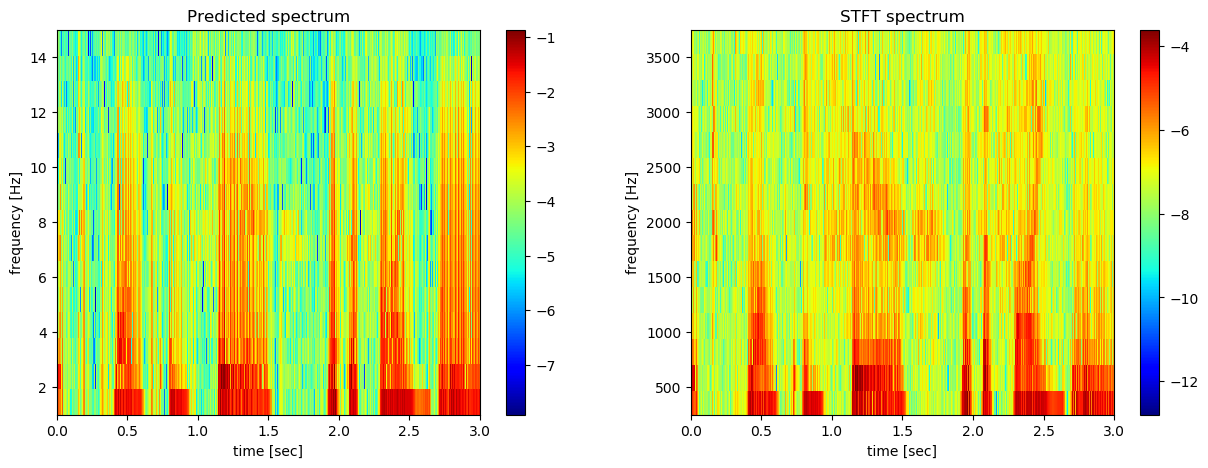

In [9]:
# convert μ_x to a 1d array
#μ_x_pred = expand((hcat(μ_x...),dims=1))

# convert s_x to a 2d array
if length(size(μ_s)) != 2
    μ_s = hcat(μ_s...)
end

# calculate magnitude spectrum
mag_μ_s = log10.((μ_s[1:length(freq),:].^2 + μ_s[length(freq)+1:end,:].^2))


# create figure with subplots
fig, ax = plt.subplots(ncols=2, figsize=(15,5))

# plot speech signal as a function of time
cmp = ax[1].imshow(mag_μ_s,
                   aspect="auto",
                   cmap="jet",
                   origin="lower",
                   extent=[minimum(t), maximum(t), 1, length(freq)])
fig.colorbar(cmp, ax=ax[1])

# plot spectrogram of speech signal
plot_spectrogram(spectrogram(x_time, 2*length(freq)+1, 0, fs=fs_desired), fs_desired, ax=ax[2], colorbar=true)

# change visuals
ax[1].set_xlim(minimum(t), maximum(t)), ax[2].set_ylim(minimum(freq), maximum(freq)), ax[1].set_xlabel("time [sec]"), ax[1].set_ylabel("frequency [Hz]"), ax[1].set_title("Predicted spectrum"), ax[2].set_title("STFT spectrum")
#cmp.set_clim(-3, -16)
;

<source src="data:audio/wav;base64,UklGRjx3AQBXQVZFZm10ICgAAAD+/wEAQB8AAAB9AAAEACAAFgAgAAAAAAADAAAAAAAQAIAAAKoAOJtxZGF0YQB3AQCyNdq9fvMVvmWapL3/Q6a9AFZSvc9bhrxbqog9APvGPRAxIz4Lg4A+WHB8Ph/CYD42B28+fjEOPqQ1kTw0E9m8gpAQvfZh8b0tskW+wysQvpkeir0M0Ei9NlMOvdMfnzuJZE89x4eEPT5Ryjv7lda8zlRCvfIIob2wOry9Fdb0vYdKDL5hWv697KzDvTWHqb0slyS9vLzHPIb18D0Vkx4+9ghSPrDydT5RRIQ+Klt7PrXWLj6hWjI9gMOlvG7f7rzt0ey9ZHBEvu/zRL46PMG93MMTvXsnL71EYKK8wr5EPXJ7Mj2lcik9H/83O+sSn7z3mYK9aEtyvWmZw72eAgC+nWbqvTVC6r0ykKy99KMovWtnpDxxTQM+PlZQPhL/Zz6eIpU+HaeTPvX/UT5pj5I9V2r/O3d167qn+Ii97DxdvooiYb6vnB6+naimvQXN1b0Wq4i90GfhPMfRvj3RUn89VBWQPARZNTvB+gw93J8mvREjr72+yea9GSgBvjOU+L2uada9Ee+5vQwgHbwpQqo9KwMyPgpURj68gmM+SbCSPkeUfT6cwwQ+nCqAPMJajjzUIUK8RWIZvp5HgL6MpS++BlvKvUNN4r2U/ce94YoqvfctGD081hA9rD9VPYJvKjyYy/I73+GSPJY+Bzt4MqW9qCPbva6cgb2mOLe8QWLlvCirWT06C0I+gjdnPgZ5bD7VS3I+dZUJPidUiz16tDc9y2b0OnlLGL6DE1O+hK4Jvrj/A75WRhS+ceTXvUNBCDzztZI94VaiPf2apz2RyYU9syxOPUQAOT1SCnE8ZjhwveCcCr7Gwui9sFO4vTbELL4Skge+wcuqvMAUDz0ysD891Xi3PXDXDT4ZeCw+GCgWPorQCT4vYtM9tdVLPW49wzww99G8V6MDvagciLzaBaS9RLT3vR5nsL0tFEu9MRGGvc9yOb3+zT68qq0TO+NUfbvAiB69LVG6vBX9BbwCSvO7VImxu208zzxKrpo9pLL9PeeoMD5b5lM+979jPkmKYj70YKg9XruWvOYdvDwRuC69iwtGvkLXY74vsa+9QRuqvYJwIr5Lxte9M3NPPeMRvD23RHM9hC+kPZs3/j0/9e89EpG6PTcDjTxFFRa9Xqe6vXJxl73Usvm9T3AMvoXaur32Liy9ELAdvQXPBL1/OKK74+MgPTkfaj2hfDw9jQ4PPQHNRT3CfXA8U4bpvAbcZL15X5u8iJ2tvMFiPb3F5Em8kdpHvKBrzDtIMxQ7r9toPDtf07qHvuK7OTkLPIcpBbwh0v284dbBuzH4lbt0cKi8Z3U1Ow6ACzwjC3Q8YTiUPOFYwzypx/E8dvk4PfdkLj2tBi49CRwAPalhvjwLwHK895cXvUY/7bw4vDC9GUSxvPUEVb1Relm9/faMvGxINr1f3hG9oTB0vHEOgby5I7+7Mz+HvKYHM7pfPVQ7kx/TPGmpRT3a6V09m+FAPSKbUT1Vv1Y9vz1wPYVlSD0VXwI9WMqTPMxd2Ttn5S29bOeSvdyDoL1ko6q9aIyQvatCv70i16u9IfGCvboXML15zw+9wDGdvNa2jLgvXQ88A/+uPOrISj2RCxY96VZcPcXhwz17Qtw9tMb/PSH23T1g5989tSGWPboxGT3bXo68qciDvdJO+L17++y9Ta8HviCOKr4OGvy93BSqvfnVeb1pxpi9CAK9vHEPlTt/KQo9BLgpPcS0hj3Xvqc9JVOuPekwsD0iwOw9Mj4cPhXRKz7g7uI9zCz7PFrGjTwrYjI9gVcpvd7ZB7566bu9FQJnve/d271V3ga+GkGJvVvrszuKgsu8V7aiu3/mID0Cj5s9xa8uPdg6njw5wTw9FKvlPK7oAL0rvMS4PLE2vXprLr2EqoS9NHaBvZQja71xGEW9HDnbvKfluLyxXGi8fXBBvFvHEby4exU8L4tzPLHjdbzdB1O81itNPHKHc7kS3d47htbOu8g+2zsDDhk8PbW8vH5SATvnPqG7P9jsOsyg+bwL1C08tXqvPIBjMzzFMCw8dZIHO5+TvTwR+To7JTQlu3qA/rurZac7SS0PPSOa9TsPtbw8AwJRPDk9CDzxQUS7h+E6u8ErrrtU3TC8Q1WFvN+ZW7zNYpi8d3Pvu1/jirytm0+7RUHLuqxF+LuKXjg8+uXDPGnNBz13r6u8+3MAPMR2wTyV9TQ8tmObOpWLVDzI3A89sSTiO/wCdzxbitS8spOVvDP+4Tu7wnG7b/F2ux/+wrqmZ987cYXPuweEoTyyQp28TvIFvKuAPbw1x5A8i38OPM3EszkUvAs8IDzyPJkSoDu/LHW8hpHgO7mfiDwhRIg8w9ieu4a5+TviefI8qUsbuvZAdToAENw87s7DOu5ANzyElZ88VzahPKky5rtju8U71LmXPA3KjrzKRQk76lsWu33lxTnGJVg8l7sDvPkIvrzO4Lc7Lz2FPC4tO7yTC+m8lVBQPJd/mDwnV3W8BIc8u5oUZjuXs3u8HPmZvLkZDz2D/ug604IXvQzPhry4HYY7p6EEvC1B57xPeN06RIU3O2IdOrz5q6y8enfZvG3hMzoG9Zw8jp2nvGf8F73BDK86l3xdPJso9LzW4oq8niQPPIu7aby2bpi8rg80u2zEcbxyuD68HMi2vCLUKrwL7lC8Zt0evPWIh7zgq0y7iXIUuyRDkruJU3G8bvyPOQo/RjyvmyA8cg3wu6KHDrynb9S7VAooPBpzrbrZPcs722GVvDevLjz6Oya5YMtxvFhrTrxuf2u8bQSTvNQepjz3LNu7H2foO0WyrTtnY027OMVOu2dR+LpS07W8q6zkvDZBujv51Xw62z/CvEzlLLw1TyS8Yk4YOhBXFrzZesW6NOAGvOBlFLwHmyI7MemIOhCjiTwOVeW7pQAJO+Nr5zvDwSO8WQoYvNZ5IDx2R+u7hLPqujylqbs3Fog8KjpmOrSnObwGgy+8e+wMPG91ELzzfes7O4rgu5NoT7sw2rc6JooRPPBoWTureCQ8z7oAOk4YiDzJdQu7wrWlu+dLVLsR6S48sCw1uwEPLzxe+YU85RMEPEz/iDw39Vg7k/u7O/VYl7twQqe7cBA7u+wpczzbSaC71V+iPMiwtbuQIvm6Onq7PBI5z7rCkci7kEcnPJAWabscr+A7L9fqOhl9FjxRWfq6CxGHPIbRuDt1sVc76cbHOpA4FzvlTtg5uaQMvNR6BzxiUj27I9AmuwkME7wpmLC63nUfPB3XWzymp187H8aGu/TFA7weZcu7Vq6ovMdxfbyqs4S7i7byuxpNHrwulo47TlIlum+/rLz2PvW7Zd4ROrCLGzxH/Xu7tvMcu/O7DrzJb1G8OSxyvPsRrbtRpb68zx22vOuGLrtS/zC8QYi6vCBtFbzxp9S8iDzru1ERQLwBLXw7dzFru4ReDLzg1EO8UPU2vLygEL3rSx69QEkUPBVgQbw0N9G8UGBivALvQbvETdo6XFo6vEc5Crw7pQS8jHyZu1u/T7yr4I87xYQ8vEztGrx4NoQ8ugBwvIZSQLxqZvS8PKy5vGaosbvUvrq7rV9kvNI2gjsTyE06FGeOu8atsTvg0ZG86YvzvAxK5TobQEm8vw9nu5zuk7xthys7bR/AuyV+ObvPNyQ6Y0gOvBbMh7rI06a83vWOPDID2jvs57i6VUMUPPFVzrtPkaq7YMmJu68tl7trkIO7NMqRO5fG1TusGR49FImlup08+ztjS088m0smPGd7sjxHQMK6lF9LPOTY/jukqeQ8pxrIu4ZR8zs9+d+6St26O6RjazxZtT46MTxiPELMgryTRgg8y/lru+SHEzzw6Sm8MkwePPkAjzu6EX48kDbbO5V/BLp93Ai6AMbmu/6txjxxV1o8yXAUumNNDjzlx

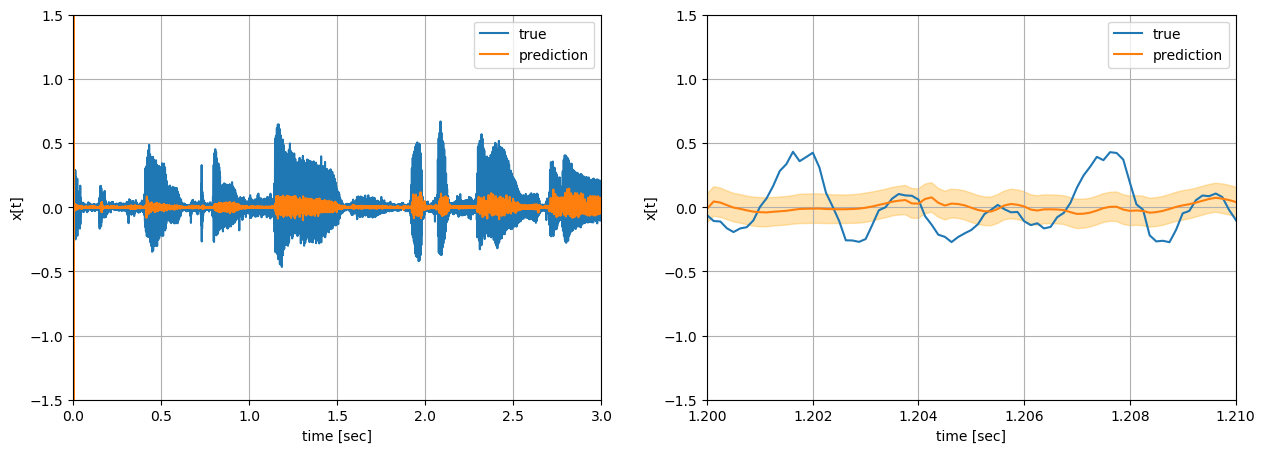

In [10]:
# create figure with subplots
fig, ax = plt.subplots(ncols=2, figsize=(15,5))

μ_x_pred_select = simplify(reverse(hcat(μ_x...), dims=1))
var_x_pred_select = expand([reverse(diag(Σ_x[k])) for k =1:length(Σ_x)])

# plot actual, noisy and marginal of frequency component
ax[1].plot(t, x_time, label="true"), ax[1].plot(t[1:length(μ_x_pred_select)], μ_x_pred_select, label="prediction")#, ax[1].plot(t[1:length(μ_x_pred_norm)], μ_x_pred_norm, label="normalized prediction")
ax[2].plot(t, x_time, label="true"), ax[2].plot(t[1:length(μ_x_pred_select)], μ_x_pred_select, label="prediction")#, ax[2].plot(t[1:length(μ_x_pred_norm)], μ_x_pred_norm, label="normalized prediction")
ax[2].fill_between(t[1:length(μ_x_pred_select)], μ_x_pred_select .- sqrt.(var_x_pred_select), μ_x_pred_select .+ sqrt.(var_x_pred_select), alpha=0.3, color="orange")

# change vizualization
ax[1].grid(), ax[1].set_xlim(0,3), ax[1].set_ylim(-1.5, 1.5), ax[1].set_xlabel("time [sec]"), ax[1].set_ylabel("x[t]"), ax[1].legend()
ax[2].grid(), ax[2].set_xlim(1.2,1.21), ax[2].set_ylim(-1.5, 1.5), ax[2].set_xlabel("time [sec]"), ax[2].set_ylabel("x[t]"), ax[2].legend()

plt.savefig("figures/all_AR01.png", dpi=500)

# create audioplayers
audioplayers(x_time, x_time_clean, μ_x_pred_select, fs=fs_desired)
;

## Performance metrics

In [11]:
MSE = 1/length(μ_x_pred_select) * sum(abs.(μ_x_pred_select - x_time[1:length(μ_x_pred_select)]).^2)

0.01697522704884755

In [12]:
MAE = 1/length(μ_x_pred_select) * sum(abs.(μ_x_pred_select - x_time[1:length(μ_x_pred_select)]))

0.06855923442391203

In [13]:
using Distributions;
logBME = Float64[]
# initialize buffer
buf = BufferData(x_time, t, buffer_size)
for k = 1:length(μ_x)
    try 
        push!(logBME, sum([1/buffer_size*logpdf(Distributions.Normal(μ_x[k][ki], sqrt(Σ_x[k][ki,ki])), buf.buffer_s[ki]) for ki=1:buffer_size]))
    catch
    end
    step!(buf, step_size)
end
print("nr: "* string(length(logBME))* "       mean:"* string(mean(logBME)))

nr: 799       mean:0.8174262732295285